In [66]:
%matplotlib notebook
import os
import tempfile

import pandas as pd
import matplotlib.pyplot as plt 
import matplotlib

ard_path = f"{tempfile.gettempdir()}/ard.csv"
cap_path = f"{tempfile.gettempdir()}/cap.csv"
lagwinapp_path = f"{tempfile.gettempdir()}/lagwinapp_msgs.csv"

<IPython.core.display.Javascript object>


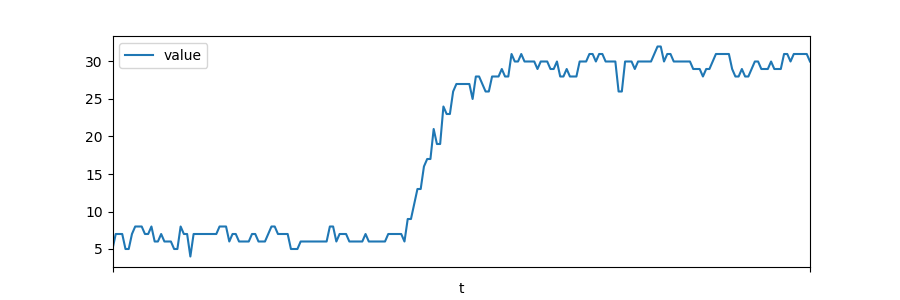

In [67]:
# Get the light readings from the arduino (dumped by lagcap.py)
ard_df = pd.read_csv(ard_path)[['t', 'value']]
ard_df['t'] = (ard_df['t'] * 1000).astype("datetime64[ms]")
ard_df = ard_df.set_index('t')
ard_df = ard_df.resample('1ms').pad()
_ = ard_df.plot(figsize=(9, 3))

In [68]:
win_msgs = None
if os.path.exists(lagwinapp_path):
    win_msgs = pd.read_csv(lagwinapp_path)
    win_msgs['t'] = win_msgs.timestampMicros.astype("datetime64[us]")
    if abs(float((win_msgs['t'].values[0] - ard_df.index[0].to_datetime64()) / 1e9)) > 1.0:
        print("win_msgs probably from a different run - omitting")
        win_msgs = None  
    
win_msgs

win_msgs probably from a different run - omitting


<IPython.core.display.Javascript object>


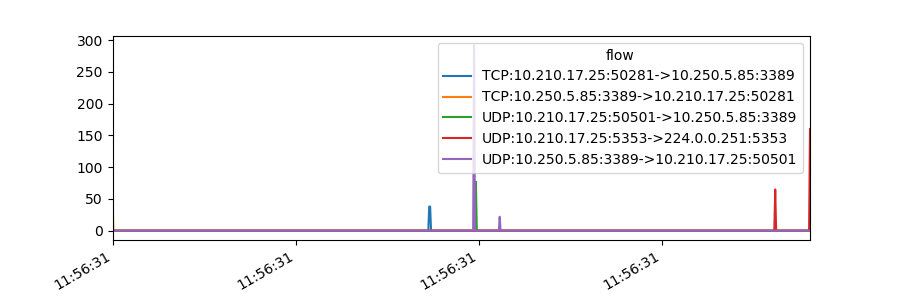

In [50]:
if os.path.exists(cap_path):
    cap_df = pd.read_csv(cap_path)
    cap_df['t'] = (cap_df['t'] * 1000).astype("datetime64[ms]")
    cap_df['flow'] = cap_df.apply(lambda r: f"{r.proto}:{r.src}:{r.srcport}->{r.dest}:{r.destport}", axis=1)
    if len(cap_df) == 0:
        cap_df = None
    elif (float(cap_df['t'].values[0] - ard_df.index[0].to_datetime64()) / 1e9) > 2:
        print("cap.csv probably from a different run - omitting")
    else:
        cap_df = cap_df.groupby(['t', 'flow']).data_len.sum().unstack().fillna(0).resample('1ms').sum()

_ = cap_df.plot(figsize=(9, 3))

<IPython.core.display.Javascript object>


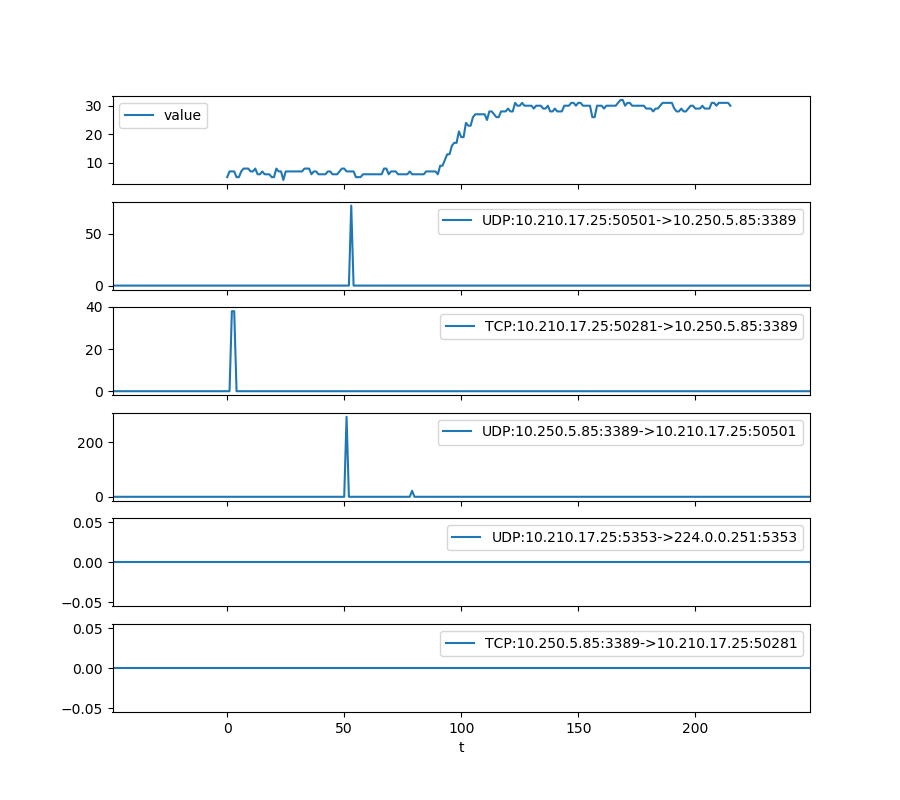

In [70]:
df = ard_df

if cap_df is not None:
    df = cap_df.join(ard_df, how='outer')

df = df.reset_index()
origin_millis = int(ard_df.index.values[0]) / 1000000
df['t'] = df['t'].apply(lambda x: int(x.to_datetime64()) / 1000000) - origin_millis

df = df[df['t'] < 250]

df = df[df['t'] > -50]

df = df.set_index('t')

cols = list(ard_df.columns) + list(set(df.columns) - set(ard_df.columns))

df = df[cols]

fig, ax = plt.subplots(len(df.columns), figsize=(9,8), sharex=True) # Create the figure and axes object

for n, c in enumerate(df.columns):
    df.plot(y = n, ax = ax if len(df.columns) == 1 else ax[n]) 
    
plt.draw()

if win_msgs is not None:
    for t in win_msgs['t']:
        t = int(t.to_datetime64()) / 1000000 - origin_millis
        plt.axvline(x=t, color='green')
